# Data exploring and preprocessing

In [ ]:
import pandas as pd
# read the data first
data = pd.read_csv('./data.csv')
data.head(10)

In [0]:
data.shape

In [0]:
data.info()

In [0]:
data['diagnosis'].value_counts()

In [0]:
col = data.columns
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
data = data.dropna()
# data.shape
data['label'] = data['diagnosis'].map({'M': 1, 'B': 0}) # prepare the binary label
data.drop(['diagnosis'], axis=1, inplace=True)

# Prepare the training set, validation set and testing set, ratio as 6:2:2

In [0]:
from sklearn.model_selection import train_test_split
random_seed = 888
data_train, data_rest = train_test_split(data, test_size=0.4, random_state=random_seed, stratify=data['label'])
data_test, data_validate = train_test_split(data_rest, test_size=0.5, random_state=random_seed, stratify=data_rest['label']) 

In [0]:
print(data_train.shape)
print(data_validate.shape)
print(data_test.shape)

In [0]:
# check if the splitting is balanced
print(data_train['label'].value_counts())
print(data_validate['label'].value_counts())
print(data_test['label'].value_counts())

# Normalization of three sets

In [0]:
from sklearn.preprocessing import StandardScaler
def get_features_and_target_arrays(input_df):
    y = input_df['label']
    x = input_df.drop(['label'], axis=1)
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
    return x_scaled, y

In [0]:
X_train, y_train = get_features_and_target_arrays(data_train)
X_test, y_test = get_features_and_target_arrays(data_test)
X_validate, y_validate = get_features_and_target_arrays(data_validate)

# Find the optimal hyperparameter C using the validation data with grid search

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define logistic regression model
logistic_reg = LogisticRegression(solver='liblinear') # liblinear is better for data of small size

# Define hyperparameters grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}  # 'C' is the inverse of lambda

# Create grid search object, using f1 score here to find a balance between recall and precision
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_validate, y_validate)

# Get the best hyperparameter
best_hyperparameter = grid_search.best_params_['C']

print("Best hyperparameter:", best_hyperparameter)

Best hyperparameter: 1


# Visualize the grid search for optimal hyperparameter

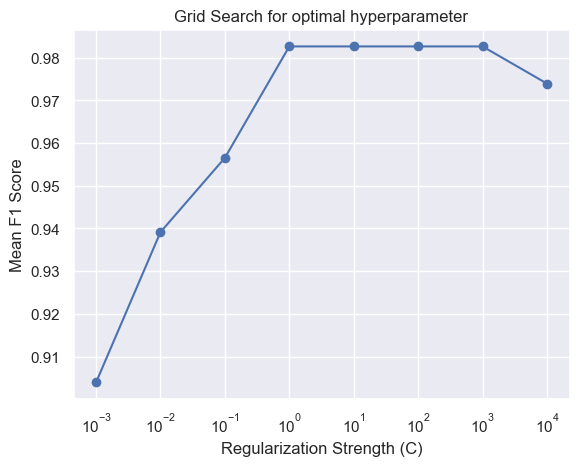

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Extract grid search results
results = grid_search.cv_results_
mean_test_scores = np.array(results['mean_test_score']).reshape(8, 1)

# Create a basic plot
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score')
plt.title('Grid Search for optimal hyperparameter')
plt.grid(True)
plt.show()


# Train the model using the best hyperparameter learnt

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Initialize logistic regression model with the optimal hyperparameter value
logistic_reg = LogisticRegression(solver='liblinear', C=best_hyperparameter, penalty='l2')

# Train the model on the entire training dataset
logistic_reg.fit(X_train, y_train)

# Predict the labels on the test dataset
y_pred_test = logistic_reg.predict(X_test)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_test)
# Print accuracy
print("Accuracy:", accuracy)

# Plot the precision and recall curve, ROC curve and the f1 threshold curve

In [0]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_pred_prob = logistic_reg.predict_proba(X_test)[:, 1]

# Compute precision and recall
precision, recall, thresholds  = precision_recall_curve(y_test, y_pred_prob)

# Compute F1 score
f1 = 2 * (precision * recall) / (precision + recall)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Compute area under the curves (AUC)
pr_auc = auc(recall, precision)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot F1 score with respect to different threshold values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1[:-1], label='F1 Score', marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()

plt.show()